# Figure 6

In [1]:
import pickle
import random

import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt

from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from pylipd.lipd import LiPD

In [2]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

In [3]:
end_time=10000

lipd_path = './data/8k_ice'
record = 'NGRIP.NGRIP.2004'

d = LiPD()
d.load(f'{lipd_path}/{record}.lpd')
df = d.get_timeseries_essentials()
row = df[df['time_variableName']=='age']
lat = row['geo_meanLat'].to_numpy()[0]
lon = row['geo_meanLon'].to_numpy()[0]
elevation = row['geo_meanElev'].to_numpy()[0]
value = row['paleoData_values'].to_numpy()[0]
value_name = row['paleoData_variableName'].to_numpy()[0]
value_unit = row['paleoData_units'].to_numpy()[0]
time = row['time_values'].to_numpy()[0]
time_unit = row['time_units'].to_numpy()[0]
time_name = row['time_variableName'].to_numpy()[0]
label = row['dataSetName'].to_numpy()[0]
geo_series = pyleo.GeoSeries(time=time,
                            value=value,
                            lat=lat,
                            lon=lon,
                            elevation=elevation,
                            time_unit=time_unit,
                            time_name=time_name,
                            value_name=value_name,
                            value_unit=value_unit,
                            label=label,
                            archiveType='ice')

series = geo_series.copy()
series.time_unit = 'Years BP'
series = series.slice((0,end_time)).interp()

Loading 1 LiPD files


  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 61.65it/s]

Loaded..
Time axis values sorted in ascending order


In [4]:
level=4
m=13
eps=1

spike_series = series.copy()
spike_series.value = np.zeros(len(spike_series.value))
index = np.where((spike_series.time >= 7800) & (spike_series.time <= 8400))[0]
spike = -1+(1/len(index))*np.arange(len(index))
spike_series.value[index] += spike
success_counter=0
noise_series = pyleo.Series(*pyleo.utils.gen_ts(model='ar1',t=spike_series.time,scale=1/level)).convert_time_unit('Years BP')
noisy_spike = spike_series.copy()
noisy_spike.value += noise_series.value

apply_series=noisy_spike.convert_time_unit('Years')
amt_series = amt.Series(
    time=apply_series.time,
    value=apply_series.value,
    time_name = apply_series.time_unit,
    value_name = apply_series.value_name,
    time_unit = apply_series.time_unit,
    value_unit = apply_series.value_unit,
    label = apply_series.label,
    sort_ts=None
)
td = amt_series.embed(m=m)
eps_res = td.find_epsilon(eps=eps,target_density=.05,tolerance=.01)
print(f'Tau is {td.tau}')
rm = eps_res['Output']
lp_series = rm.laplacian_eigenmaps(w_size=20,w_incre=4)
lp_series = lp_series.convert_time_unit('years BP')

Time axis values sorted in ascending order
Initial density is 0.0571
Initial density is within the tolerance window!
Tau is 3


Text(0, 0.5, 'Temperature')

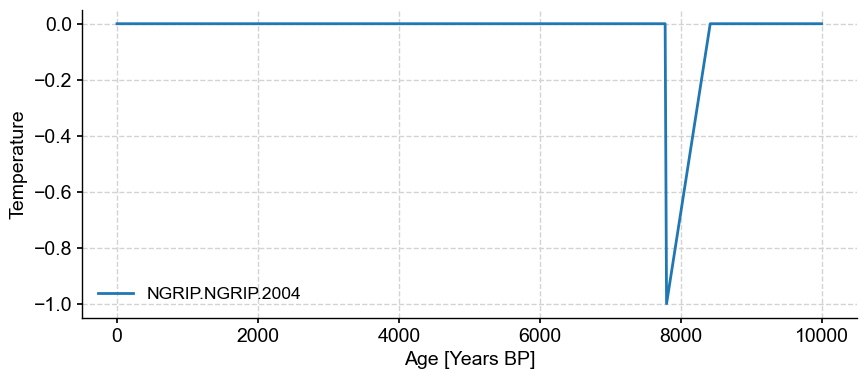

In [5]:
fig,ax=spike_series.plot()

ax.set_ylabel('Temperature')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [Years BP]', ylabel='value'>)

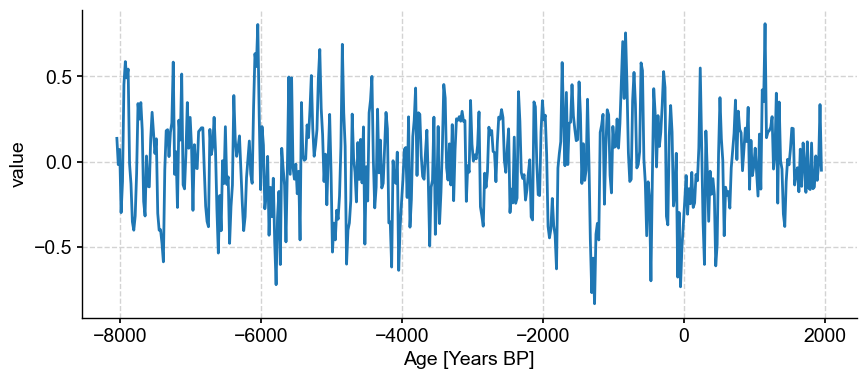

In [6]:
noise_series.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [Years BP]', ylabel='d18O [permil]'>)

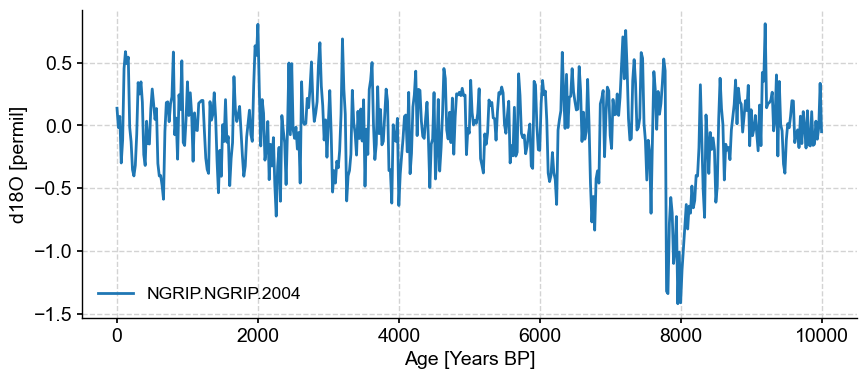

In [7]:
noisy_spike.plot()

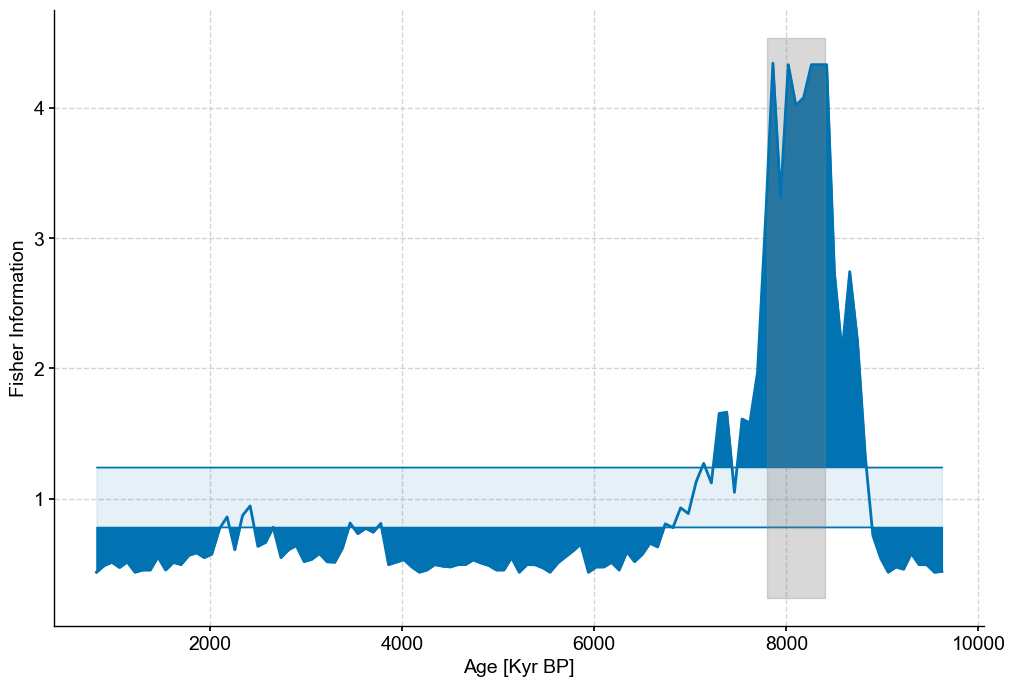

In [8]:
fig,ax=lp_series.confidence_fill_plot()

ax.set_ylabel('Fisher Information')
ax.set_xlabel('Age [Kyr BP]')
ylim=ax.get_ylim()
ax.fill_betweenx(ylim,7800,8400,color='grey',alpha=.3)
ax.legend().set_visible(False)

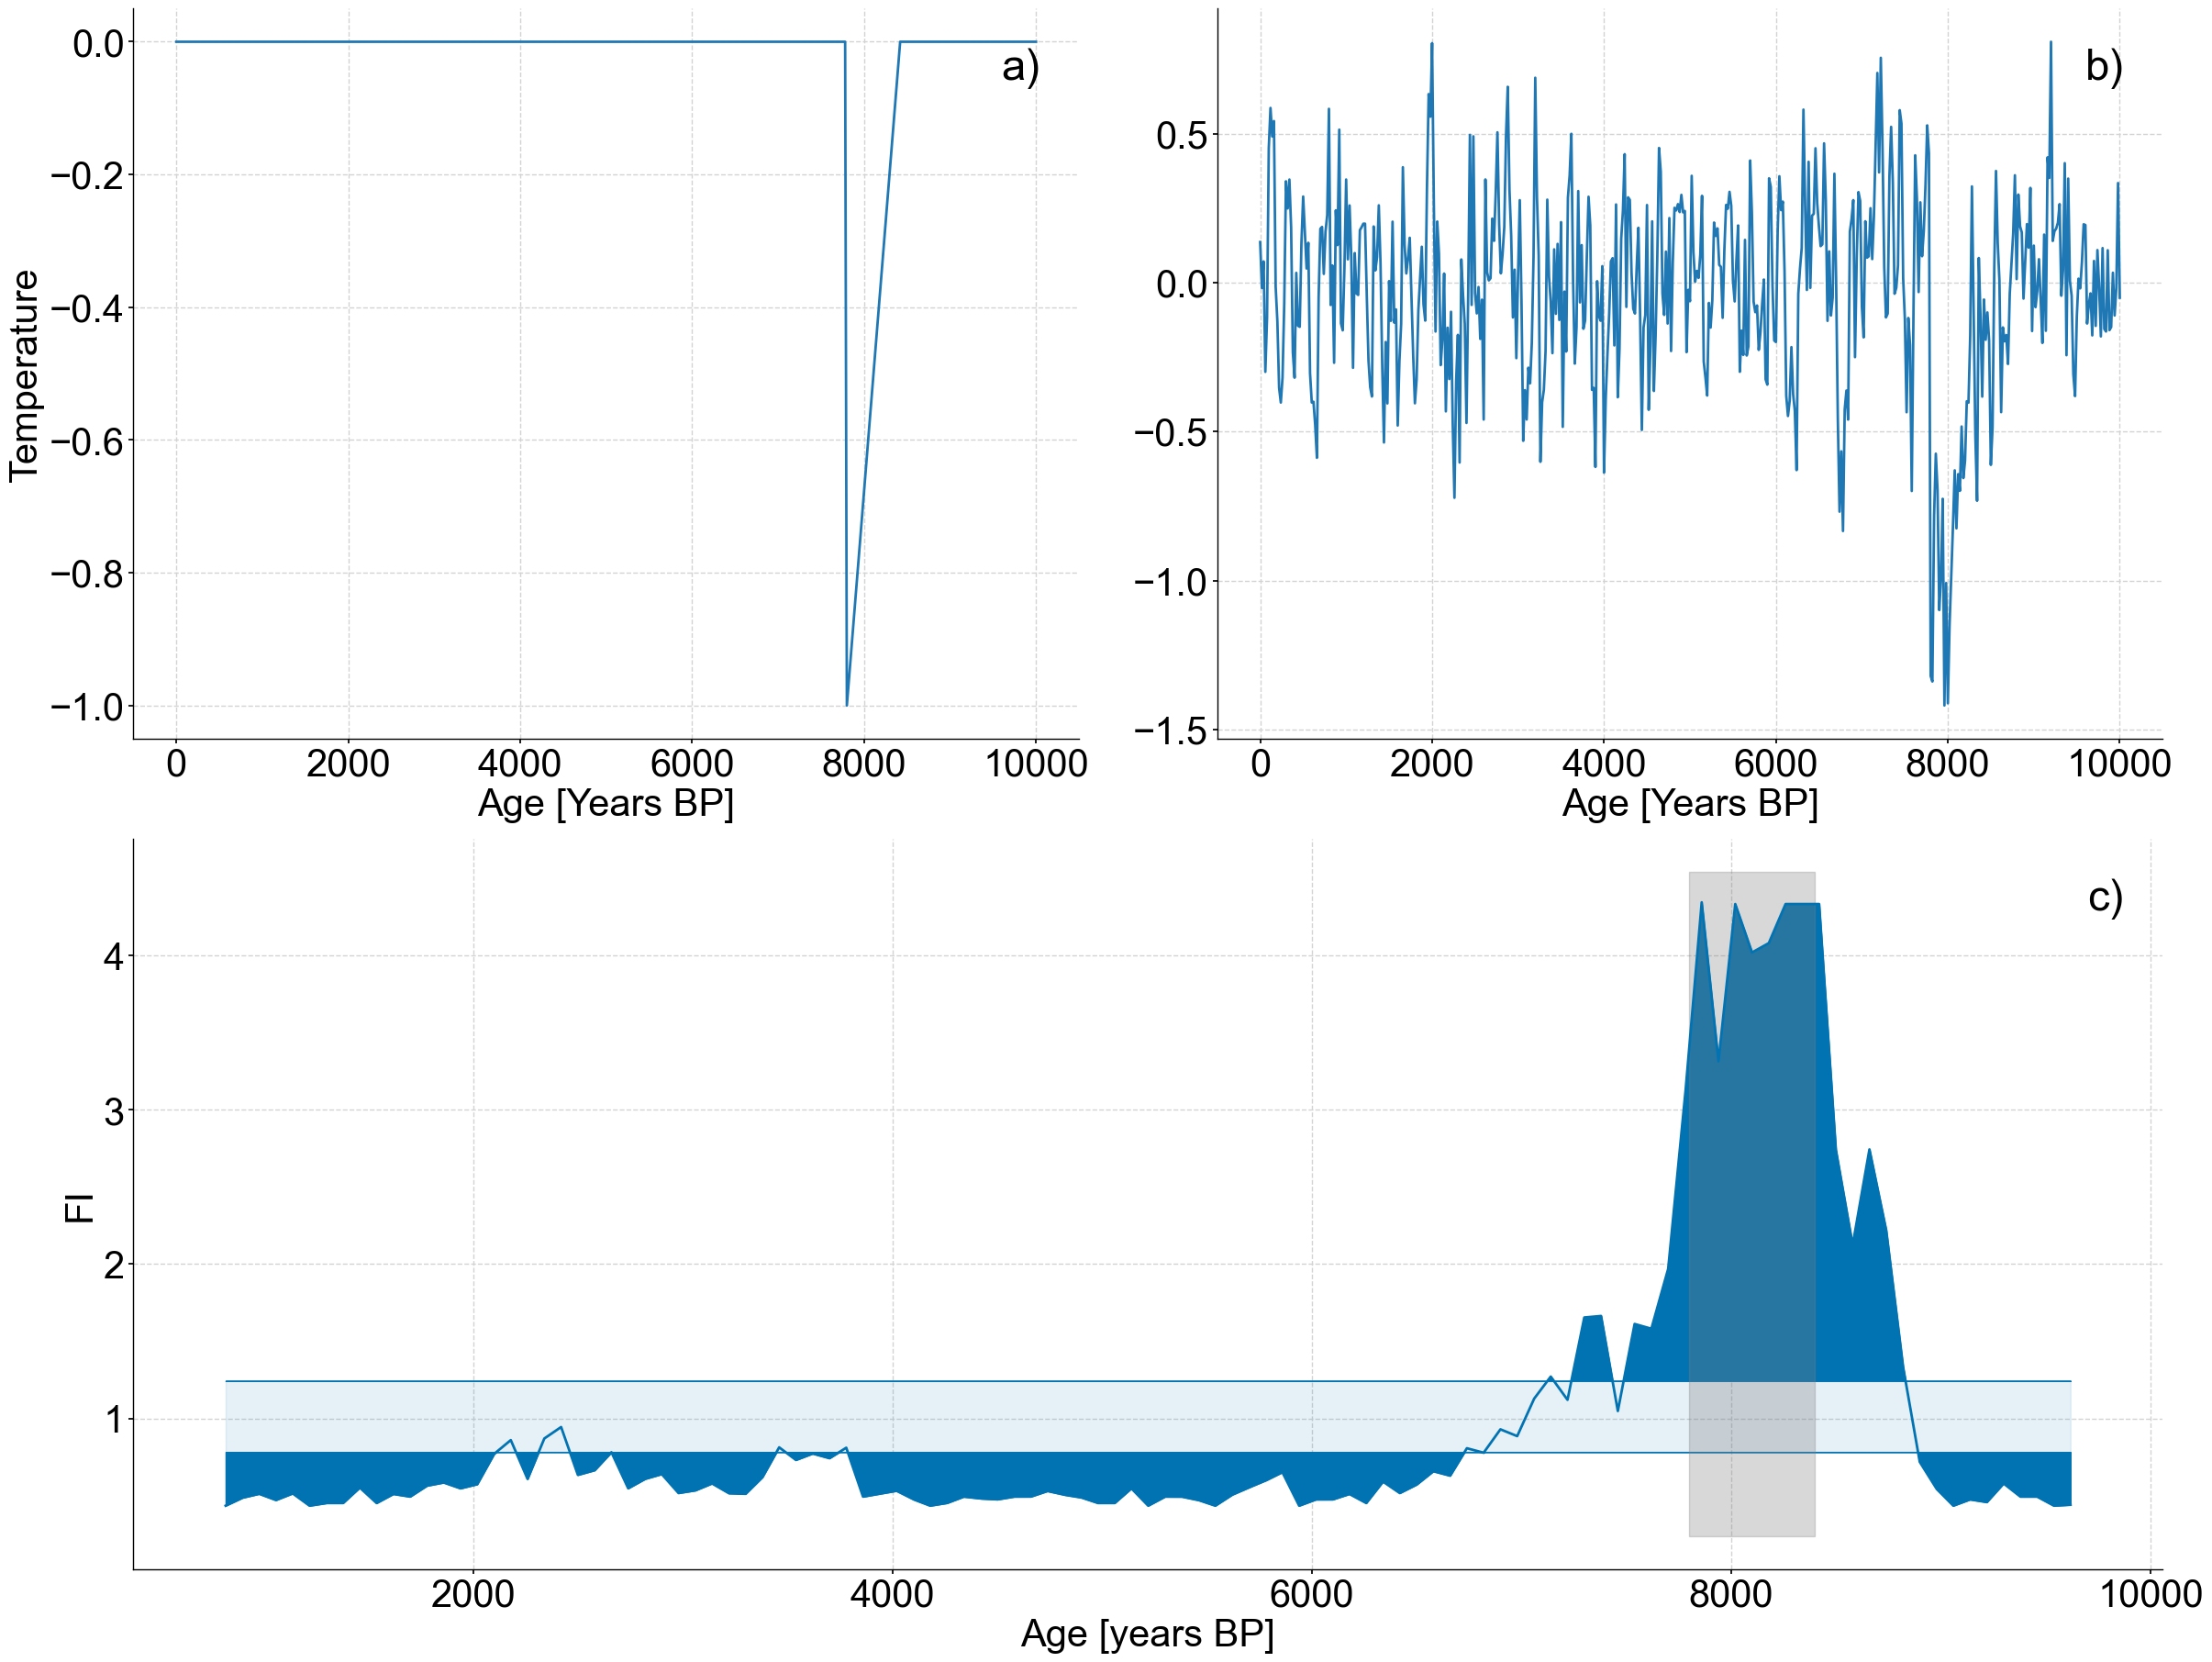

In [9]:
#Production figure

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 34

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(constrained_layout=True,figsize=(24,18))
gs = GridSpec(2, 2, figure=fig)
 
# create sub plots as grid
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

spike_series.plot(ax=ax1,legend=False,ylabel='Temperature')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='a)')
ax1.legend(handles=[patch],loc='upper right')

noisy_spike.plot(ax=ax2,legend=False,ylabel='')
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='b)')
ax2.legend(handles=[patch],loc='upper right')

lp_series.confidence_fill_plot(ax=ax3,legend=None,ylabel='FI')
ax3.fill_betweenx(ylim,7800,8400,color='grey',alpha=.3)
patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='c)')
ax3.legend(handles=[patch],loc='upper right')